In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold
import scipy.io as sio
import seaborn as sns
import scipy.optimize
import pickle
import pandas as pd
from analysis_utils import *
sns.set_context("talk")

# Import outside packages by changing the path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'glmhmm')))
from glmhmm import glm, glm_hmm, utils, analysis
from glmhmm.utils import permute_states, find_best_fit, compare_top_weights
from glmhmm import visualize

# code from Brody Summer Project
sys.path.append(os.path.abspath(os.path.join('..', '..', 'LC_PWM_GLM-HMM/code')))
import io_utils, analysis_utils, plotting_utils

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

sns.set_context("talk")

In [2]:
### Fitting Iris' standard GLM-HMM models for IBL 3 features data for each animal from witten lab and until session 40

In [2]:
ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject'])
print(subjectsWitten)

['ibl_witten_02' 'ibl_witten_03' 'ibl_witten_04' 'ibl_witten_05'
 'ibl_witten_06' 'ibl_witten_07' 'ibl_witten_12' 'ibl_witten_13'
 'ibl_witten_14' 'ibl_witten_15' 'ibl_witten_16']


In [4]:
dfAll.head()

,contrastLeft,contrastRight,choice,feedbackType,probabilityLeft,lab,subject,date,session,correctSide
0,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
1,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
2,0.0,1.0,1,1,1.0,angelakilab,IBL-T1,2019-02-09,1,1
3,0.5,0.0,0,1,0.5,angelakilab,IBL-T1,2019-02-09,1,0
4,0.5,0.0,0,1,0.9,angelakilab,IBL-T1,2019-02-09,1,0


In [7]:
x, y , sessInd = get_mouse_design(dfAll, subject='ibl_witten_15', sessStop=-1, D=4)
print(x)
print(np.unique(x[:,1]))

[[ 1.          0.92036171  0.          0.        ]
 [ 1.          1.85796066  0.          0.        ]
 [ 1.          1.85796066  1.          0.        ]
 ...
 [ 1.          1.85796066  1.          1.        ]
 [ 1.          0.45156223  1.          0.        ]
 [ 1.         -0.01723724  1.          0.        ]]
[-1.89243515 -0.9548362  -0.48603672 -0.25163698 -0.13443711 -0.01723724
  0.09996262  0.21716249  0.45156223  0.92036171  1.85796066]


# Fitting all animals together

In [3]:
# make dataset with all mice from Witten lab for specific D

D = 4

firstSubject = 'ibl_witten_02'
x, y, sessInd = get_mouse_design(dfAll, firstSubject, sessStop=-1, D=D)
for subject in subjectsWitten:
    if (subject != firstSubject):
        xTemp, yTemp, sessIndTemp = get_mouse_design(dfAll, subject, sessStop=-1, D=D)
        x = np.concatenate((x,xTemp))
        y = np.concatenate((y,yTemp))
        sessInd = sessInd + [x + sessInd[-1] for x in sessIndTemp[1:]]
print(x)
np.save(f'../data_IBL/X_allAnimals_D={D}', x)
np.save(f'../data_IBL/Y_allAnimals_D={D}', y)
np.save(f'../data_IBL/sessInd_allAnimals_D={D}', sessInd)
 

[[ 1.          0.66431135  0.          0.        ]
 [ 1.          0.66431135 -1.         -1.        ]
 [ 1.         -0.7802686   1.         -1.        ]
 ...
 [ 1.          0.0342067   1.         -1.        ]
 [ 1.          0.0342067  -1.          1.        ]
 [ 1.          0.27423389 -1.         -1.        ]]


In [4]:
D = 4

x = np.load(f'../data_IBL/X_allAnimals_D={D}.npy')
y = np.load(f'../data_IBL/Y_allAnimals_D={D}.npy')
y = y.astype(int)
sessInd = np.load(f'../data_IBL/sessInd_allAnimals_D={D}.npy')
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data(x, y, sessInd, folds=2, blocks=10, random_state=1)

# only fitting half a dataset for faster results
x = trainX[0]
y = trainY[0].astype(int)
sessInd = trainSessInd[0]
for K in [1,2,3,4]:
    # Set hyperparameters
    N = x.shape[0] # number of data/time points for the indirect pathway cohort
    C = 2 # number of observation classes
    D = x.shape[1] # number of GLM inputs (regressors)
    
    if (K==1):
        inits = 2
    else:
        inits = 20
    maxiter = 300 # maximum number of iterations of EM to allow for each fit - Iris has 250
    tol = 1e-4

    # store values for each initialization
    lls_all = np.zeros((inits,maxiter))
    real_GLMHMMs = np.zeros((inits),dtype=object)

    # fit the model for each initialization
    for i in range(inits):
        print("Init ", i)
        real_GLMHMMs[i] = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli",gaussianPrior=1)
        # initialize the weights
        A_init, w_init, _ = real_GLMHMMs[i].generate_params(weights=['GLM',-2,2.2,x,y,1])
        # fit the model                     
        lls_all[i,:], A, w, pi = real_GLMHMMs[i].fit(y,x,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessInd) 
            
    # Check to see that multiple fits achieve the same log-likelihood 
    fig, axes = plt.subplots(1,1)
    fig.set_size_inches(8, 4)
    topixs = visualize.plot_loglikelihoods(lls_all, maxdiff=0.15, ax=axes, startix=5) # colored in red are the ones (within maxdiff) to the best
    axes.set_title('log like')
    print(topixs)

    # find the initialization that led to the best fit
    bestix = find_best_fit(lls_all) 
    best_GLMHMM = real_GLMHMMs[bestix]

    # save the best fit - only for when large number of initializations and iterations!
    pickle.dump(best_GLMHMM, open(f'../data_IBL/IBL_allAnimals_bestGLMHMM_D={D}_states-' + str(K) + '.pickle', 'wb'))


Init  0
Init  1
[0 1]
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
[ 0 10 14 17]
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10


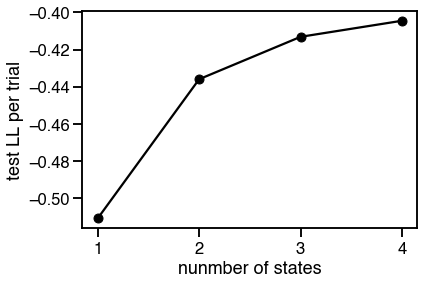

In [21]:
# Calculating test LL on the other half of all animal dataset and fit models
D = 4
x = np.load(f'../data_IBL/X_allAnimals_D={D}.npy')
y = np.load(f'../data_IBL/Y_allAnimals_D={D}.npy')
y = y.astype(int)
sessInd = np.load(f'../data_IBL/sessInd_allAnimals_D={D}.npy')
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data(x, y, sessInd, folds=2, blocks=10, random_state=1)
test_size = testX[0].shape[0]
testLl = np.zeros((4))
# evaluate log-likelihood on each test set
for K in [1,2,3,4]:
    
    # convert true weights into observation probabilities for each state
    phi = np.zeros((test_size,K,2))
    bestGLMHMM = pickle.load(open(f'../data_IBL/IBL_allAnimals_bestGLMHMM_D={D}_states-' + str(K) + '.pickle', 'rb'))
    for k in range(K):
        phi[:,k,:] = bestGLMHMM.glm.compObs(testX[0],bestGLMHMM.w[k,:,:])
    
    true_GLMHMM = glm_hmm.GLMHMM(test_size,D,2,K,observations="bernoulli")
    # compute true and inferred log-likelihoods
    testLl[K-1],_,_,_ = true_GLMHMM.forwardPass(testY[0],bestGLMHMM.A,phi)

plt.plot([1,2,3,4],testLl/test_size,'-o',color='black')
plt.ylabel("test LL per trial")
plt.xlabel("nunmber of states")
plt.show()




In [8]:
D = 5
subject = 'ibl_witten_15'
for K in [1,2,3]:
    bestGLMHMM = pickle.load(open(f'../data_IBL/IBL_allAnimals_bestGLMHMM_D={D}_states-' + str(K) + '.pickle', 'rb'))
    print(np.round(bestGLMHMM.A,3))

    x, y, sessInd = x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=-1, D=D)
    wTemp = bestGLMHMM.w
    wTemp[:,:,:] = - wTemp[:,:,:] # all weights have opposite sign in my code vs Iris'
    w = np.repeat(wTemp[np.newaxis], sessInd[-1], axis=0)
    np.save(f'../data_IBL/W_IBL_allAnimals_bestGLMHMM-Iris_D={D}_{K}-state', w)
    np.save(f'../data_IBL/P_IBL_allAnimals_bestGLMHMM-Iris_D={D}_{K}-state', bestGLMHMM.A)

    xlabels = ['bias', 'stimulus intensity','previous choice','previous reward']
    legend = []
    fig, axes = plt.subplots(1,figsize=(12,6))
    fig.suptitle('all animals')
    for i in range(1,K+1):
        legend.append('state ' + str(i))
    visualize.plot_weights(wTemp[:,:,-1],axes,xlabels=xlabels,switch=False,style='.-',error=None,label=legend) # w has shape K x D x C (but first column = 0 for C=2)
    axes.legend()

[[1.]]


NameError: name 'subject' is not defined

[[1.]]
[[0.996 0.004]
 [0.014 0.986]]
[[0.989 0.004 0.007]
 [0.016 0.979 0.005]
 [0.019 0.004 0.977]]


FileNotFoundError: [Errno 2] No such file or directory: '../data_IBL/IBL_allAnimals_bestGLMHMM_D=5_states-4.pickle'

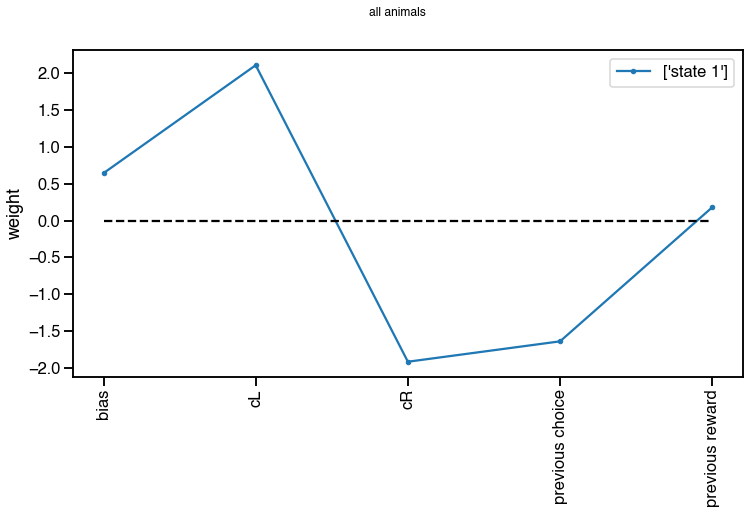

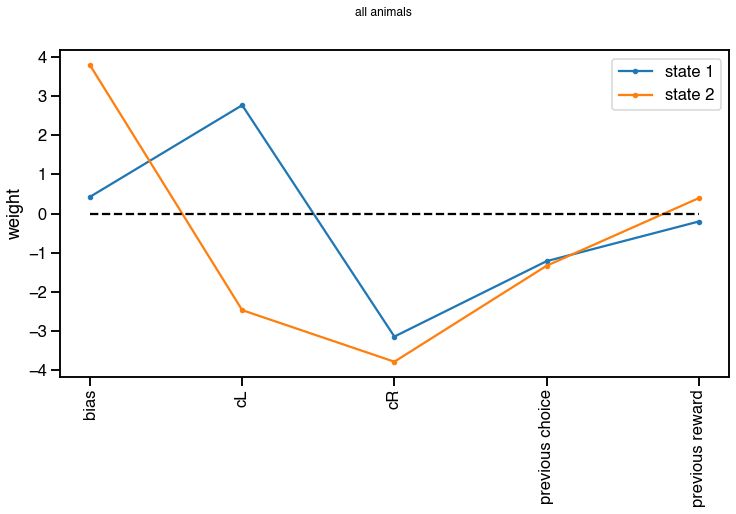

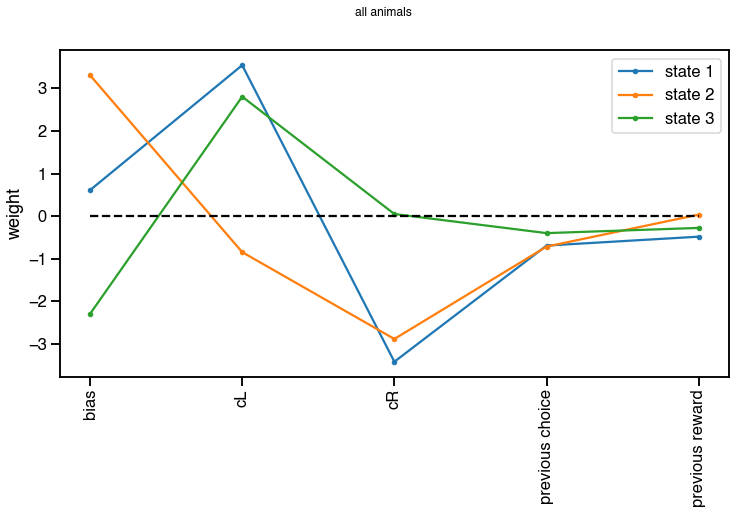

In [14]:
# saving paramters and visualizing weights
D = 5
subject = 'ibl_witten_15'
for K in [1,2,3,4]:
    bestGLMHMM = pickle.load(open(f'../data_IBL/IBL_allAnimals_bestGLMHMM_D={D}_states-' + str(K) + '.pickle', 'rb'))

    # Iris' visualization
    # for easy comparison permute the states in order from highest to lowest self-transition probability
    A_permuted, order = permute_states(bestGLMHMM.A)
    w_permuted,_ = permute_states(bestGLMHMM.w,method='order',param='weights',order=order)
    print(np.round(A_permuted, 3))
    # xlabels = ['bias', 'stimulus intensity','previous choice','previous reward'] # D=4
    xlabels = ['bias', 'cL','cR','previous choice','previous reward'] # D=5
    legend = []
    fig, axes = plt.subplots(1,figsize=(12,6))
    fig.suptitle('all animals')
    for i in range(1,K+1):
        legend.append('state ' + str(i))
    visualize.plot_weights(-w_permuted[:,:,-1],axes,xlabels=xlabels,switch=False,style='.-',error=None,label=legend) # w has shape K x D x C (but first column = 0 for C=2)
    axes.legend()

    # my visualization
    print(np.round(bestGLMHMM.A,3))
    x, y, sessInd = x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=-1, D=D)
    wTemp = bestGLMHMM.w
    wTemp[:,:,:] = - wTemp[:,:,:] # all weights have opposite sign in my code vs Iris'
    w = np.repeat(wTemp[np.newaxis], sessInd[-1], axis=0)
    np.save(f'../data_IBL/W_IBL_allAnimals_bestGLMHMM-Iris_D={D}_{K}-state', w)
    np.save(f'../data_IBL/P_IBL_allAnimals_bestGLMHMM-Iris_D={D}_{K}-state', bestGLMHMM.A)

    xlabels = ['bias', 'stimulus intensity','previous choice','previous reward']
    legend = []
    fig, axes = plt.subplots(1,figsize=(12,6))
    fig.suptitle('all animals')
    for i in range(1,K+1):
        legend.append('state ' + str(i))
    visualize.plot_weights(wTemp[:,:,-1],axes,xlabels=xlabels,switch=False,style='.-',error=None,label=legend) # w has shape K x D x C (but first column = 0 for C=2)
    axes.legend()

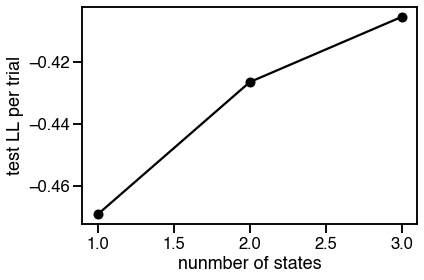

In [25]:
# Calculating test LL on the other half of all animal dataset and fit models
D = 5
x = np.load(f'../data_IBL/X_allAnimals_D={D}.npy')
y = np.load(f'../data_IBL/Y_allAnimals_D={D}.npy')
y = y.astype(int)
sessInd = np.load(f'../data_IBL/sessInd_allAnimals_D={D}.npy')
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data(x, y, sessInd, folds=2, blocks=10, random_state=1)
test_size = testX[0].shape[0]
testLl = np.zeros((3))
# evaluate log-likelihood on each test set
for K in [1,2,3]:
    
    # convert true weights into observation probabilities for each state
    phi = np.zeros((test_size,K,2))
    bestGLMHMM = pickle.load(open(f'../data_IBL/IBL_allAnimals_bestGLMHMM_D={D}_states-' + str(K) + '.pickle', 'rb'))
    for k in range(K):
        phi[:,k,:] = bestGLMHMM.glm.compObs(testX[0],bestGLMHMM.w[k,:,:])
    
    true_GLMHMM = glm_hmm.GLMHMM(test_size,D,2,K,observations="bernoulli")
    # compute true and inferred log-likelihoods
    testLl[K-1],_,_,_ = true_GLMHMM.forwardPass(testY[0],bestGLMHMM.A,phi)

plt.plot([1,2,3],testLl/test_size,'-o',color='black')
plt.ylabel("test LL per trial")
plt.xlabel("nunmber of states")
plt.show()

# Fitting GLM-HMM per animal

Init  0
Init  1
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
Init  0
Init  1
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
Init  0
Init  1
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init  12
Init  13
Init  14
Init  15
Init  16
Init  17
Init  18
Init  19
Init  0
Init  1
Init  2
Init  3
Init  4
Init  5
Init  6
Init  7
Init  8
Init  9
Init  10
Init  11
Init

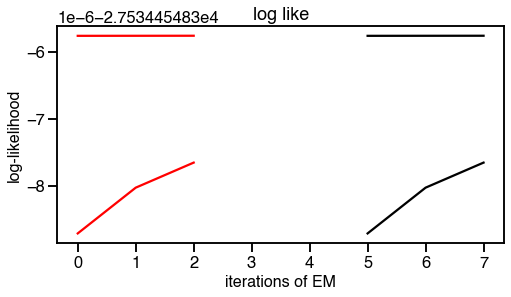

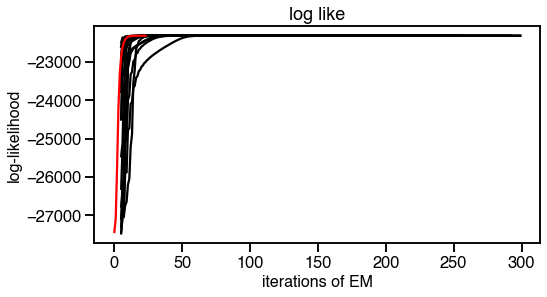

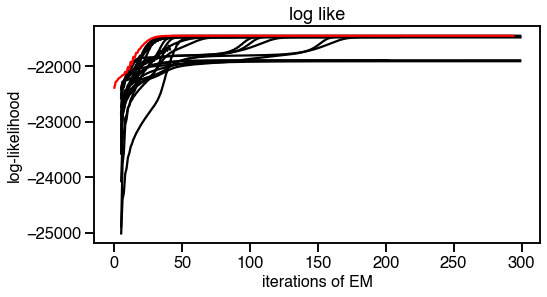

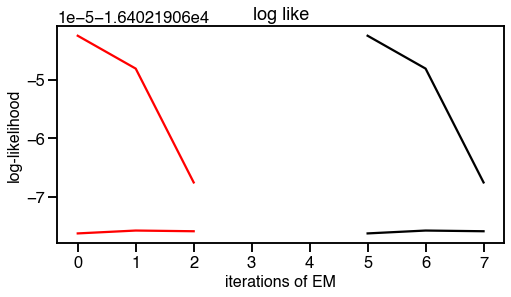

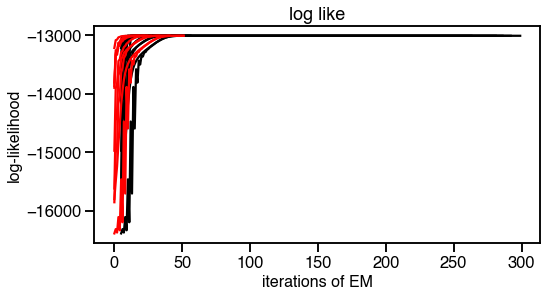

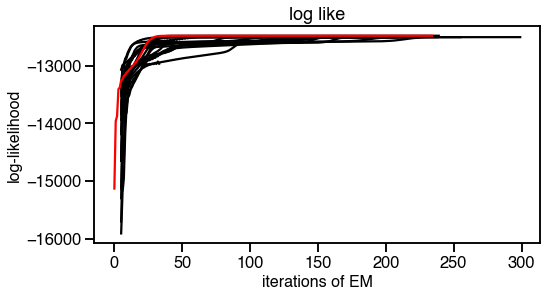

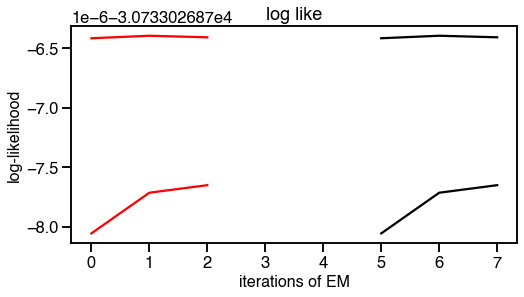

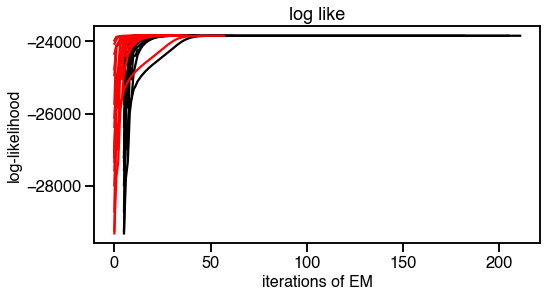

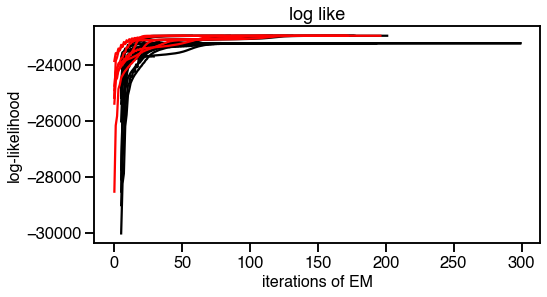

In [19]:
D = 4
for subject in ['ibl_witten_13','ibl_witten_14','ibl_witten_15','ibl_witten_16']:
    x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=-1, D=D)
    for K in [1,2,3]:
        
        # Set hyperparameters
        N = x.shape[0] # number of data/time points for the indirect pathway cohort
        C = 2 # number of observation classes

        if (K==1):
            inits = 2
        else:
            inits = 20 # set the number of initializations - Iris has 50
        maxiter = 300 # maximum number of iterations of EM to allow for each fit - Iris has 250
        tol = 1e-4

        # store values for each initialization
        lls_all = np.zeros((inits,maxiter))
        real_GLMHMMs = np.zeros((inits),dtype=object)

        # fit the model for each initialization
        for i in range(inits):
            print("Init ", i)
            real_GLMHMMs[i] = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli",gaussianPrior=1)
            # initialize the weights
            A_init, w_init, _ = real_GLMHMMs[i].generate_params(weights=['GLM',-2,2.2,x,y,1])
            # fit the model                     
            lls_all[i,:], A, w, pi = real_GLMHMMs[i].fit(y,x,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessInd) 
            
            # Check to see that multiple fits achieve the same log-likelihood 
        fig, axes = plt.subplots(1,1)
        fig.set_size_inches(8, 4)
        topixs = visualize.plot_loglikelihoods(lls_all, maxdiff=0.15, ax=axes, startix=5) # colored in red are the ones (within maxdiff) to the best
        axes.set_title('log like')
            

        # find the initialization that led to the best fit
        bestix = find_best_fit(lls_all) 
        best_GLMHMM = real_GLMHMMs[bestix]

        # save the best fit - only for when large number of initializations and iterations!
        pickle.dump(best_GLMHMM, open(f'../data_IBL/IBL_{subject}_bestGLMHMM_D={D}_states-' + str(K) + '.pickle', 'wb'))

[ 1  3  5 14 18 19 20 24]
[[[ 0.          2.80691371]
  [ 0.         -2.83475789]
  [ 0.         -0.90271782]]

 [[ 0.         -0.38889616]
  [ 0.         -2.49361159]
  [ 0.          1.84860961]]]


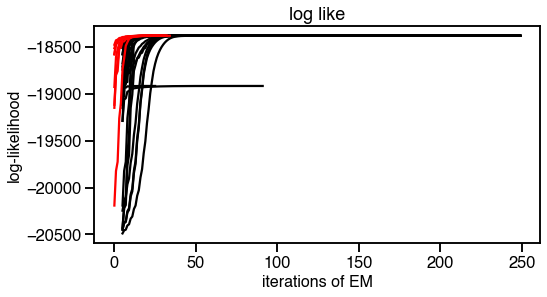

In [20]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(8, 4)
topixs = visualize.plot_loglikelihoods(lls_all[0:25], maxdiff=0.15, ax=axes, startix=5) # colored in red are the ones (within maxdiff) to the best
axes.set_title('log like')
print(topixs)

# find the initialization that led to the best fit
bestix = find_best_fit(lls_all[0:25]) 
best_GLMHMM = real_GLMHMMs[bestix]
print(best_GLMHMM.w)

[[0.979 0.021]
 [0.067 0.933]]
[[0.961 0.037 0.002]
 [0.004 0.977 0.019]
 [0.002 0.067 0.93 ]]
[[0.968 0.032]
 [0.008 0.992]]
[[0.947 0.053 0.   ]
 [0.013 0.985 0.002]
 [0.    0.016 0.984]]
[[0.961 0.039]
 [0.029 0.971]]
[[0.947 0.044 0.008]
 [0.023 0.96  0.018]
 [0.007 0.027 0.966]]
[[0.958 0.042]
 [0.01  0.99 ]]
[[0.965 0.023 0.011]
 [0.02  0.975 0.005]
 [0.029 0.009 0.963]]


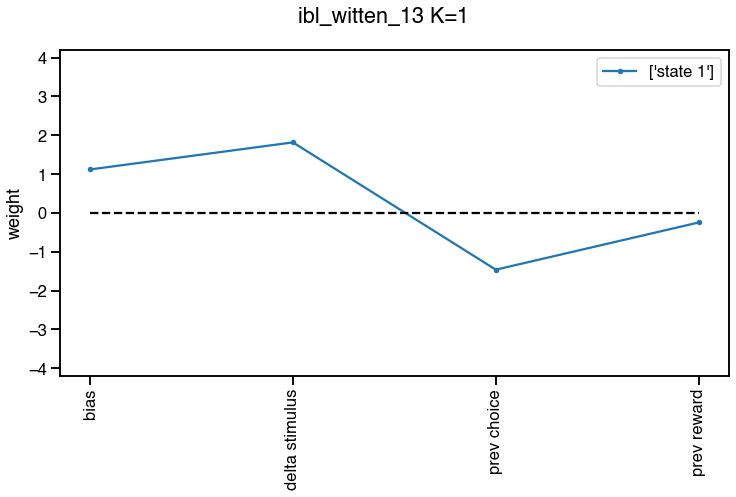

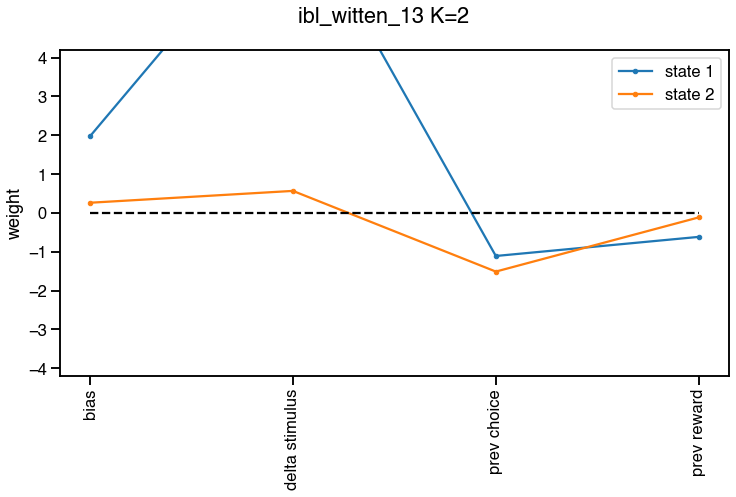

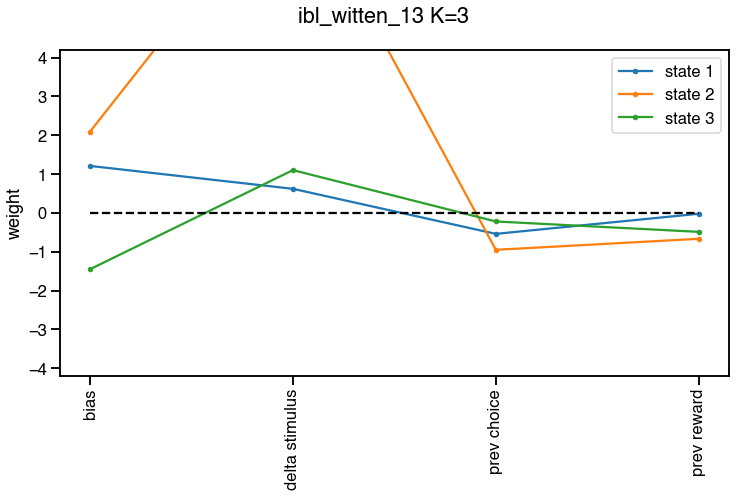

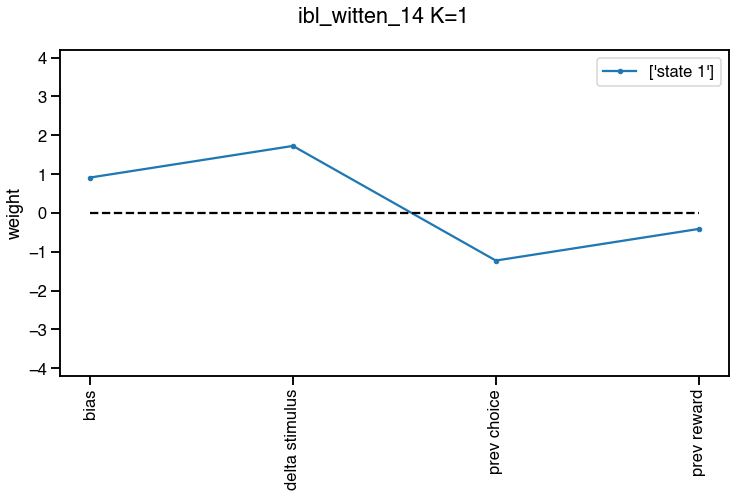

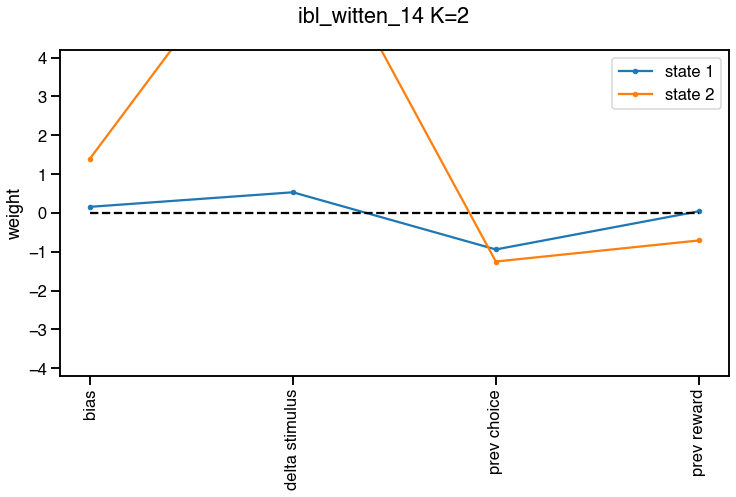

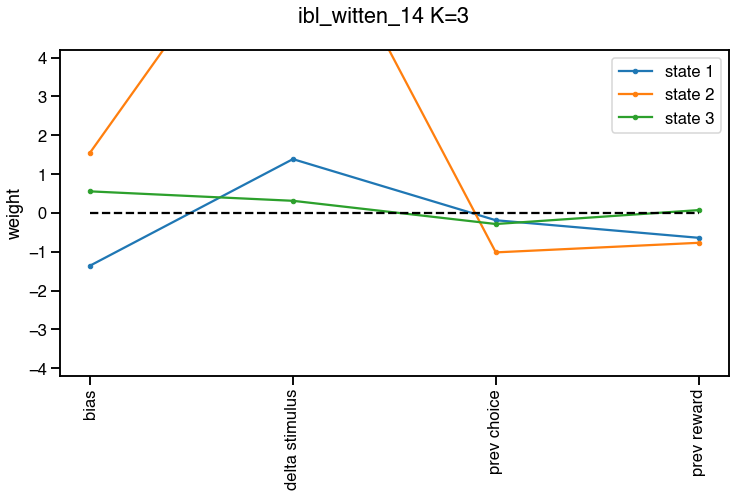

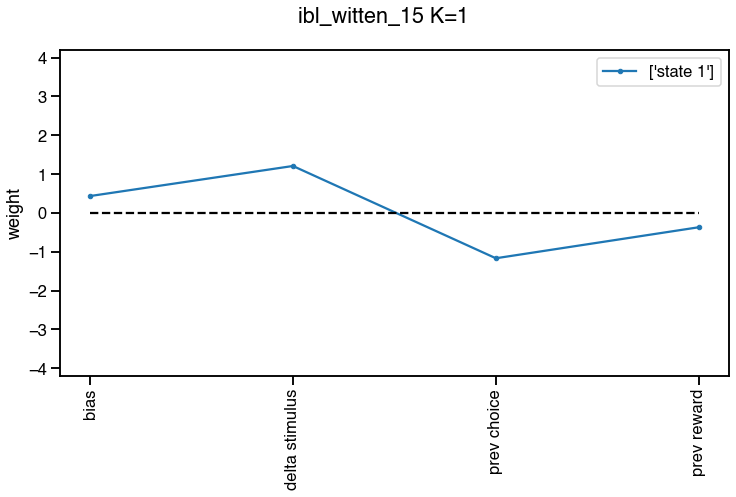

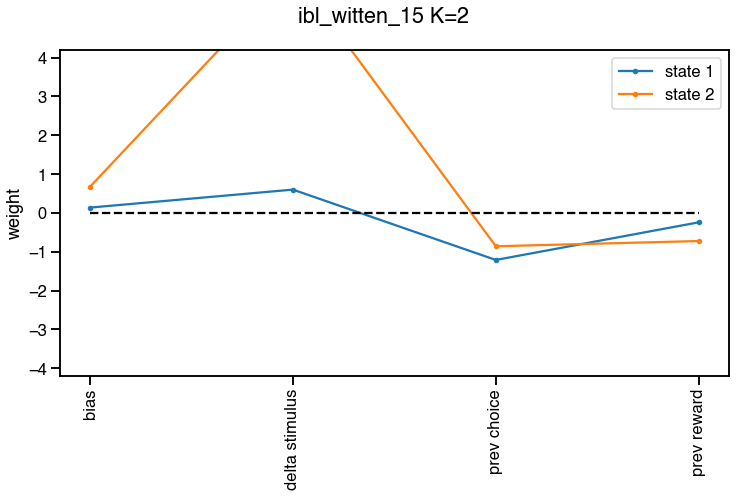

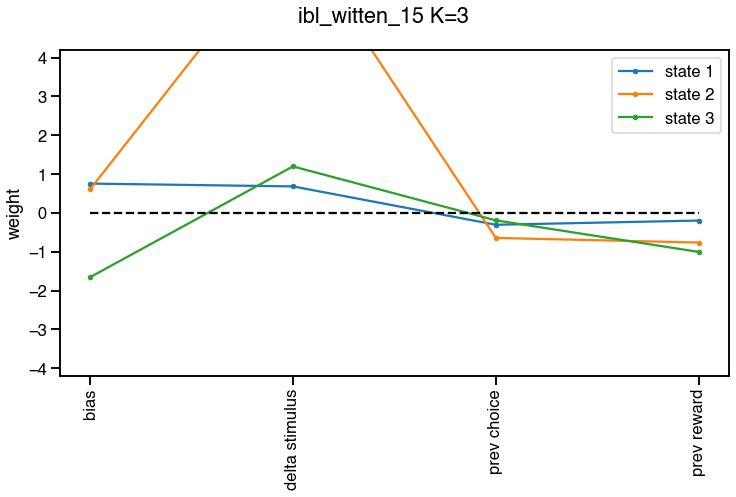

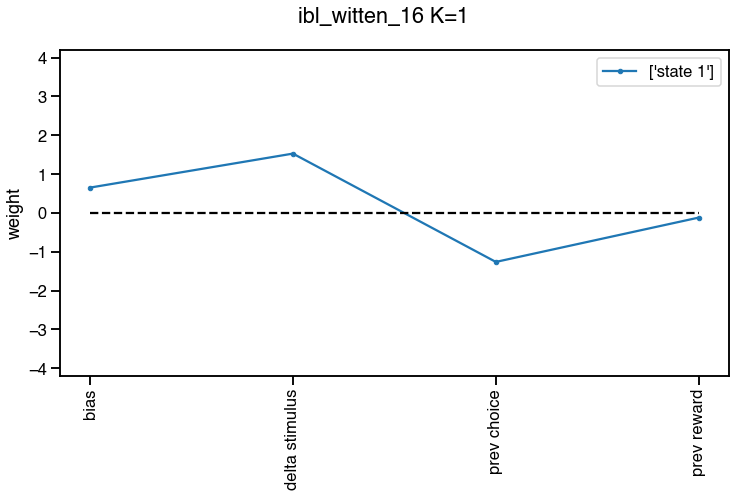

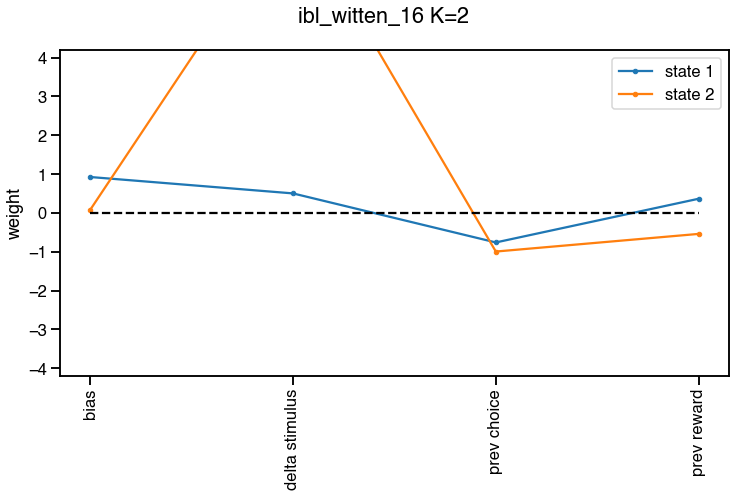

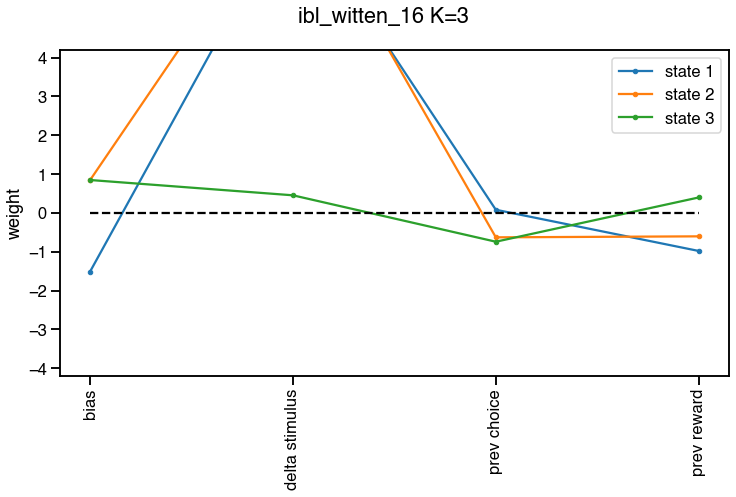

In [21]:
D = 4
for subject in  ['ibl_witten_13','ibl_witten_14','ibl_witten_15','ibl_witten_16']: #['ibl_witten_13','ibl_witten_14','ibl_witten_15','ibl_witten_16']:
    for K in [1,2,3]:
        bestGLMHMM = pickle.load(open(f'../data_IBL/IBL_{subject}_bestGLMHMM_D={D}_states-' + str(K) + '.pickle', 'rb'))
        # print(np.round(bestGLMHMM.A,3))

        x, y, sessInd = x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=-1, D=D)
        wTemp = bestGLMHMM.w
        wTemp[:,:,:] = - wTemp[:,:,:] # all weights have opposite sign in my code vs Iris'
        w = np.repeat(wTemp[np.newaxis], sessInd[-1], axis=0)
        np.save(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state', w)
        np.save(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state', bestGLMHMM.A)
        if (K==2):
            wTemp = wTemp[[1,0]]
            print(np.round(bestGLMHMM.A[[1,0],:][:,[1,0]],3))
        if (K==3):
            wTemp = wTemp[[1,0,2]]
            print(np.round(bestGLMHMM.A[[1,0,2],:][:,[1,0,2]],3))
        xlabels = ['bias', 'delta stimulus', 'prev choice','prev reward']
        legend = []
        fig, axes = plt.subplots(1,figsize=(12,6))
        axes.set_ylim(-4.2,4.2)
        fig.suptitle(subject + " K=" + str(K))
        for i in range(1,K+1):
            legend.append('state ' + str(i))
        visualize.plot_weights(wTemp[:,:,-1],axes,xlabels=xlabels,switch=False,style='.-',error=None,label=legend) # w has shape K x D x C (but first column = 0 for C=2)
        axes.legend()


[[1.]]
[[0.976 0.024]
 [0.019 0.981]]
[[0.981 0.019]
 [0.024 0.976]]
[[0.965 0.031 0.004]
 [0.037 0.959 0.004]
 [0.005 0.005 0.989]]
[[0.965 0.004 0.031]
 [0.005 0.989 0.005]
 [0.037 0.004 0.959]]
[[1.]]
[[0.975 0.025]
 [0.013 0.987]]
[[0.987 0.013]
 [0.025 0.975]]
[[0.975 0.025 0.   ]
 [0.036 0.963 0.   ]
 [0.    0.001 0.999]]
[[0.975 0.    0.025]
 [0.    0.999 0.001]
 [0.036 0.    0.963]]


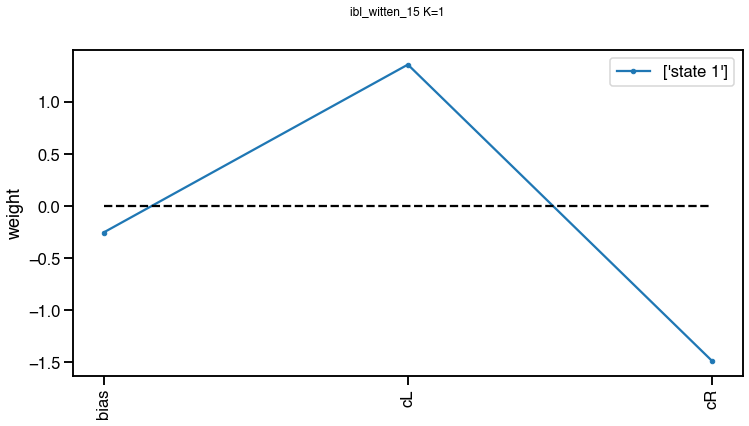

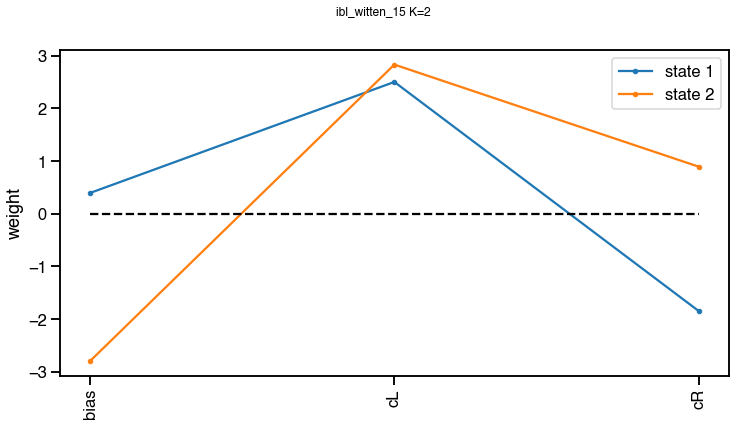

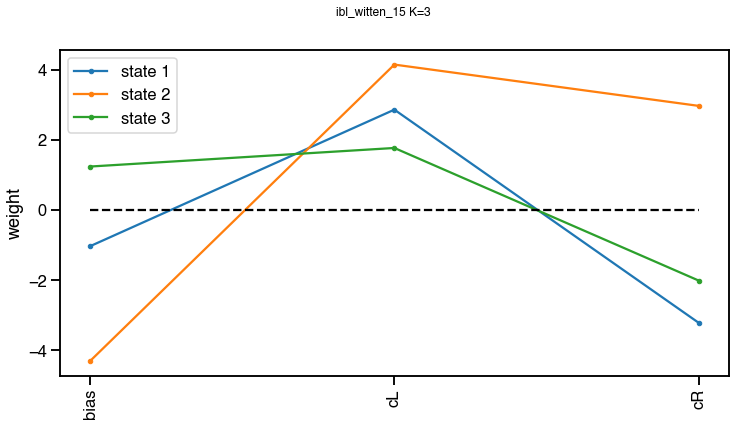

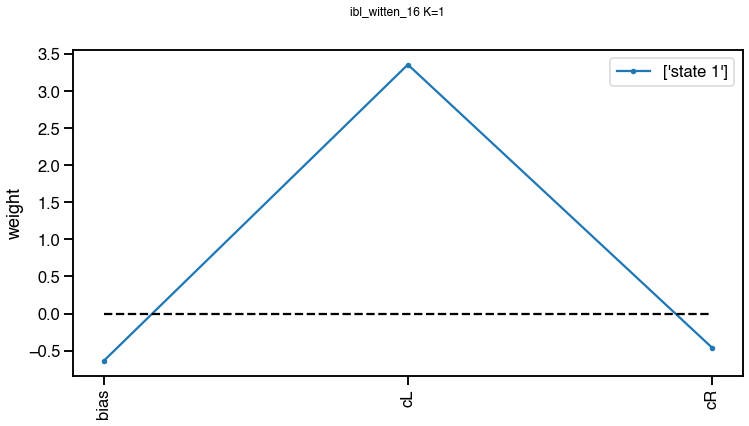

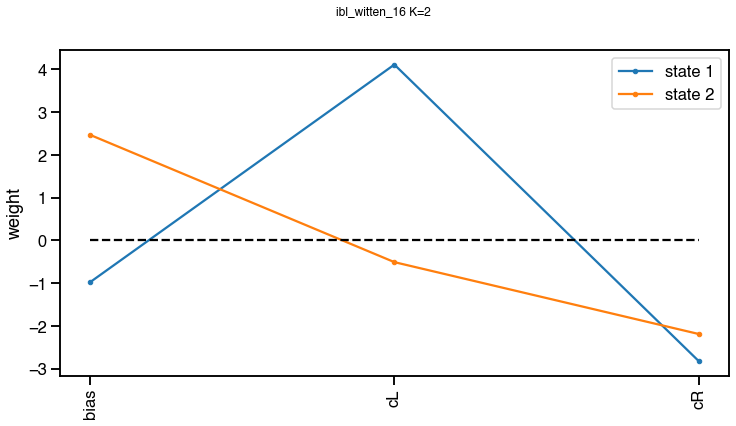

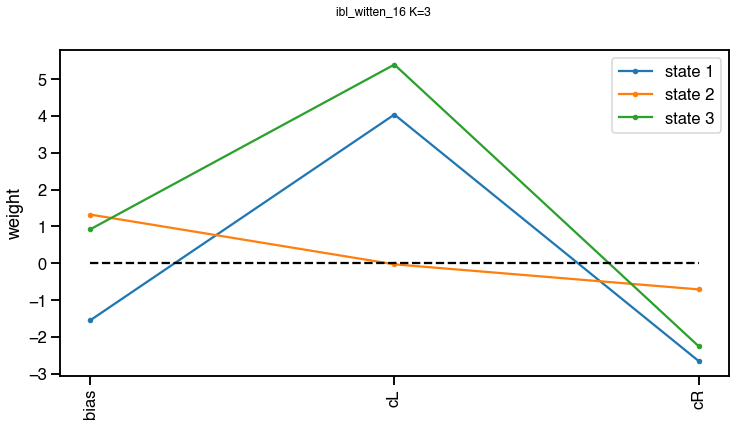

In [21]:
D = 3
for subject in  ['ibl_witten_15','ibl_witten_16']: #['ibl_witten_15','ibl_witten_16', 'ibl_witten_05']:
    for K in [1,2,3]:
        bestGLMHMM = pickle.load(open(f'../data_IBL/IBL_{subject}_bestGLMHMM__states-' + str(K) + '.pickle', 'rb'))
        print(np.round(bestGLMHMM.A,3))

        x, y, sessInd = x, y, sessInd = get_mouse_design(dfAll, subject, sessStop=-1, D=D)
        wTemp = bestGLMHMM.w
        wTemp[:,:,:] = - wTemp[:,:,:] # all weights have opposite sign in my code vs Iris'
        w = np.repeat(wTemp[np.newaxis], sessInd[-1], axis=0)
        np.save(f'../data_IBL/W_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state', w)
        np.save(f'../data_IBL/P_IBL_{subject}_bestGLMHMM-Iris_D={D}_{K}-state', bestGLMHMM.A)

        if (K==2):
            wTemp = wTemp[[1,0]]
            print(np.round(bestGLMHMM.A[[1,0],:][:,[1,0]],3))
        if (K==3):
            wTemp = wTemp[[0,2,1]]
            print(np.round(bestGLMHMM.A[[0,2,1],:][:,[0,2,1]],3))

        xlabels = ['bias', 'cL', 'cR']
        legend = []
        fig, axes = plt.subplots(1,figsize=(12,6))
        fig.suptitle(subject + " K=" + str(K))
        for i in range(1,K+1):
            legend.append('state ' + str(i))
        visualize.plot_weights(wTemp[:,:,-1],axes,xlabels=xlabels,switch=False,style='.-',error=None,label=legend) # w has shape K x D x C (but first column = 0 for C=2)
        axes.legend()